In [1]:
import sys
import os
import pandas as pd
import joblib

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, train_val_split, get_dimensions, scale, metrics_r, get_device, plot_history, load_best_params, plot_mlp_comparison, d_types_methods, get_color_map

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train, activation_funcs

## Settings

In [5]:
# Data Path
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

# Model Export Path
path_models = os.path.abspath(os.path.join(os.getcwd(), "models"))
os.makedirs(path_models, exist_ok=True)

In [6]:
# Targets
targets = ["StartYear", "YearRange"]

In [7]:
# Current Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [8]:
# Training Loss Function and Extra Metrics
criterion = nn.MSELoss()
metrics = metrics_r

In [9]:
feature_colors = get_color_map(feature_types + tuple(" + ".join(fts) for fts in feature_type_combos), "Set2")

## Data

### Read Features and Targets

In [10]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


### Train-Validation Split

In [11]:
X, y = train_val_split(X, y)

### Scale Regression Targets

In [12]:
# Scale y and get scaler
y, y_scaler = scale(y)

# Convert to tensors
y = {subset: torch.tensor(_y, dtype=torch.float32, device=device) for subset, _y in y.items()}

# Export scaler
joblib.dump(y_scaler, "y_scaler.pkl")

['y_scaler.pkl']

### Get Dimensions

In [13]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


### Torch Datasets and Dataloaders

In [14]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Best Params from Tuning

In [1]:
# Load Saved Best Params
path_params = "best_params.json"
best_params = load_best_params(path_params)

NameError: name 'load_best_params' is not defined

## Text Input MLP Model

### Compare & Choose Model

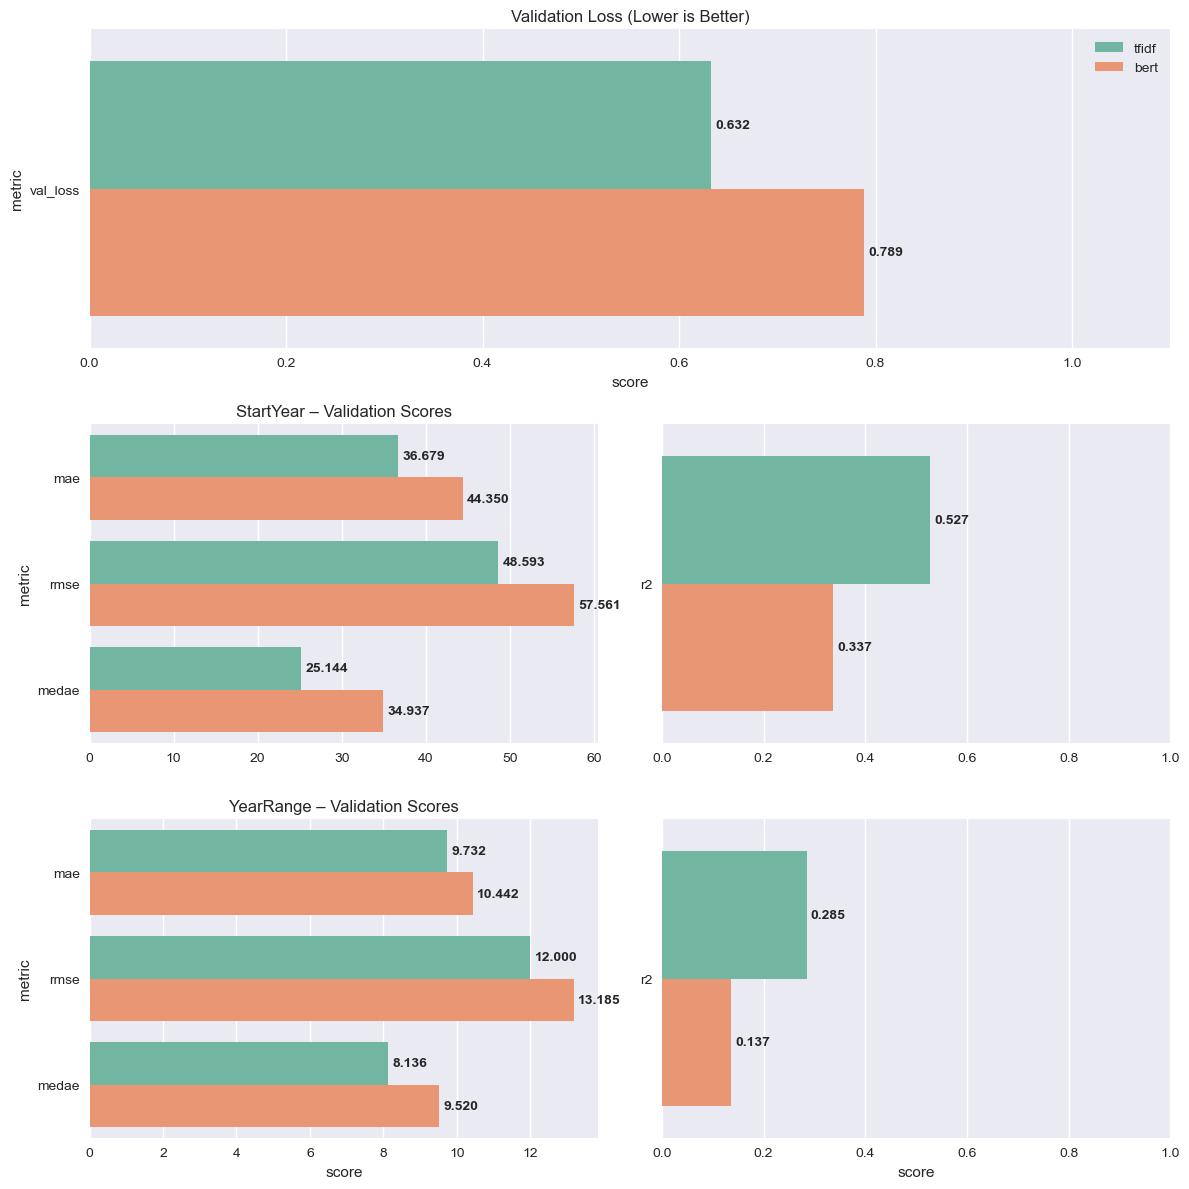

In [16]:
plot_mlp_comparison(
    {ft: best_params[ft] for ft in d_types_methods["text"]},
    {ft: feature_colors[ft] for ft in d_types_methods["text"]},
    targets
)

### Build Model

In [17]:
ft = "tfidf"
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                 relu
blocks                        2
dropout                    0.05
hidden_size                 256
hidden_size_pattern    constant
lr                         0.01
Name: value, dtype: object

In [18]:
model_txt = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_txt.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --                        --
│    └─Linear

### Train Model

In [19]:
model_txt, history_txt = train(
    model_txt,
    loaders["train"][ft],
    loaders["val"][ft],
    criterion,
    metrics,
    y_scaler,
    lr=params["lr"],
)

** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 985.97it/s, loss=0.7592]


** Early stop | ran: 13/50 epochs | final: epoch 03 | train_loss: 0.5148, val_loss: 0.7011, mae: [37.99, 10.54], rmse: [49.62, 12.95], r2: [0.51, 0.17], medae: [31.53, 9.02], 


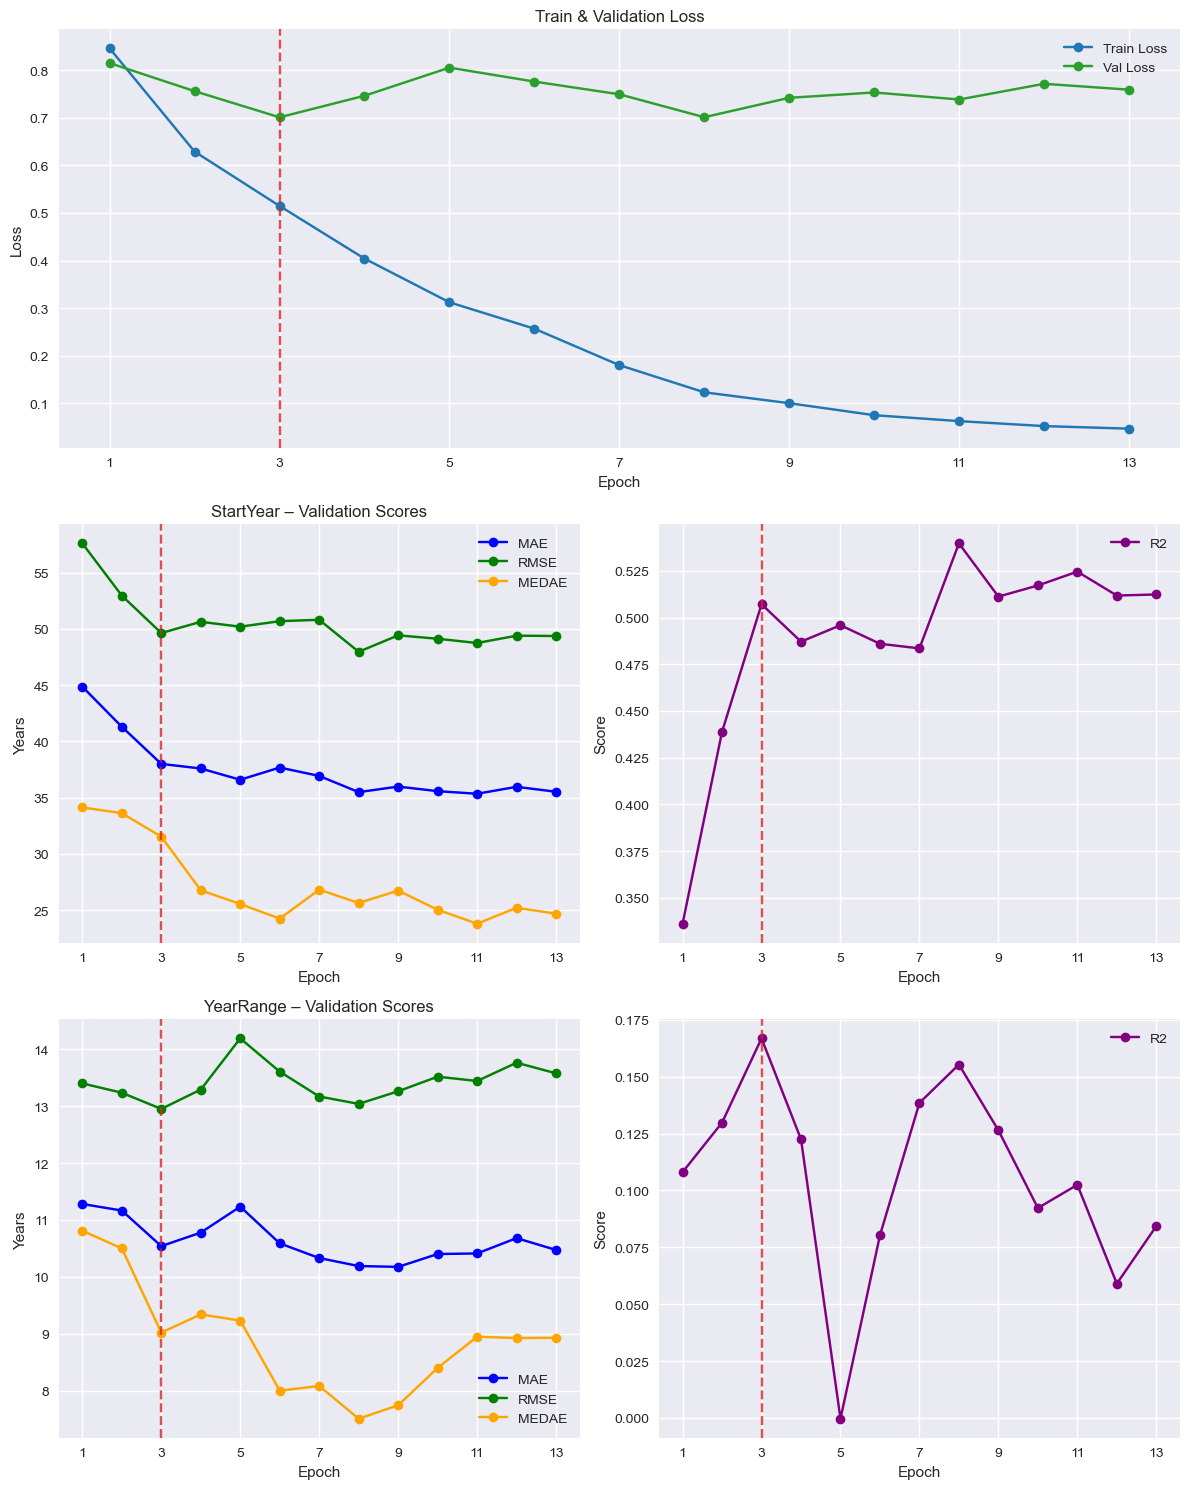

In [20]:
plot_history(history_txt, targets)

### Save Model Weights

In [21]:
path_model = os.path.join(path_models, f"pottery_chronology_predictor_{ft}.pt")
torch.save(model_txt.state_dict(), path_model)

## Image Input MLP Model

### Compare & Choose Model

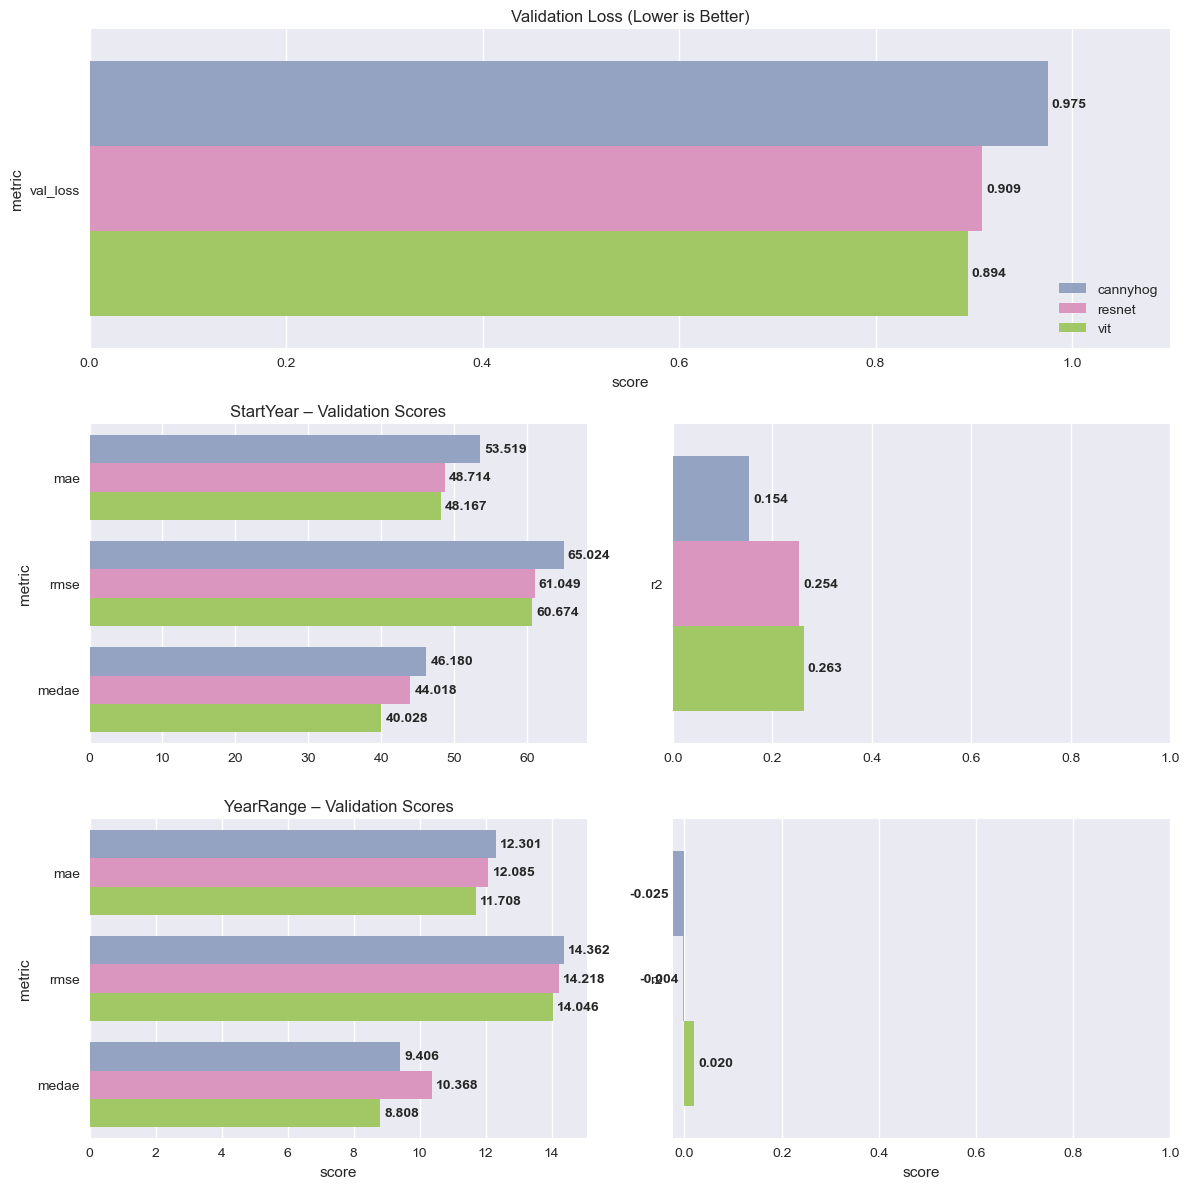

In [22]:
plot_mlp_comparison(
    {ft: best_params[ft] for ft in d_types_methods["image"]},
    {ft: feature_colors[ft] for ft in d_types_methods["image"]},
    targets
)

### Build Model

In [23]:
ft = "vit"
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                   gelu
blocks                          3
dropout                       0.1
hidden_size                    64
hidden_size_pattern    decreasing
lr                          0.005
Name: value, dtype: object

In [24]:
model_img = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_img.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 768]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 768]                  [1, 64]                   --                        --
│    │    └─Linear: 3-1                  [1, 768]                  [1, 64]                   49,216                    49,216
│    │    └─GELU: 3-2                    [1, 64]                   [1, 64]                   --                        --
│    │    └─Dropout: 3-3                 [1, 64]                   [1, 64]                   --                        --
├─Sequential: 1-2                        [1, 64]                   [1, 2]                    --                        --
│    └─Linear

### Train Model

In [25]:
model_img, history_img = train(
    model_img,
    loaders["train"][ft],
    loaders["val"][ft],
    criterion,
    metrics,
    y_scaler,
    lr=params["lr"],
)

** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1097.99it/s, loss=0.9433]


** Early stop | ran: 21/50 epochs | final: epoch 11 | train_loss: 0.7318, val_loss: 0.9159, mae: [47.91, 11.76], rmse: [60.85, 14.23], r2: [0.26, -0.01], medae: [39.38, 8.78], 


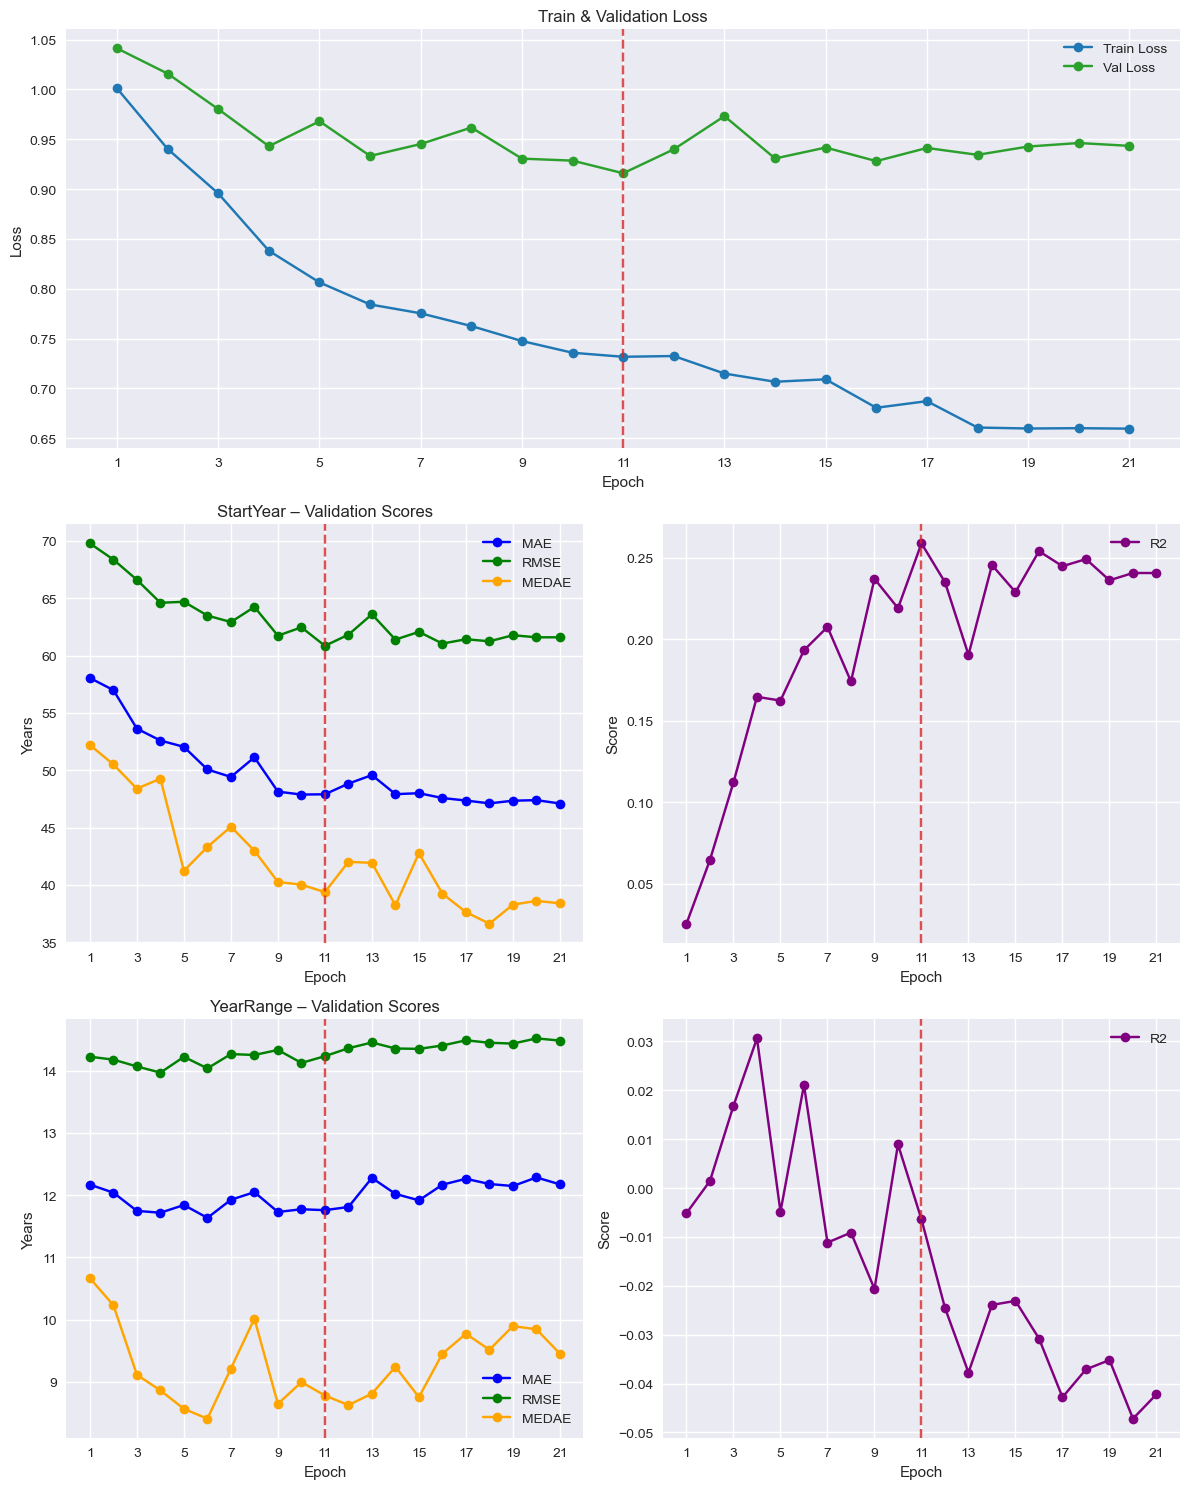

In [26]:
plot_history(history_img, targets)

### Save Model Weights

In [27]:
path_model = os.path.join(path_models, f"pottery_chronology_predictor_{ft}.pt")
torch.save(model_img.state_dict(), path_model)

## Text + Image Combo Input MLP Model

### Compare & Choose Model

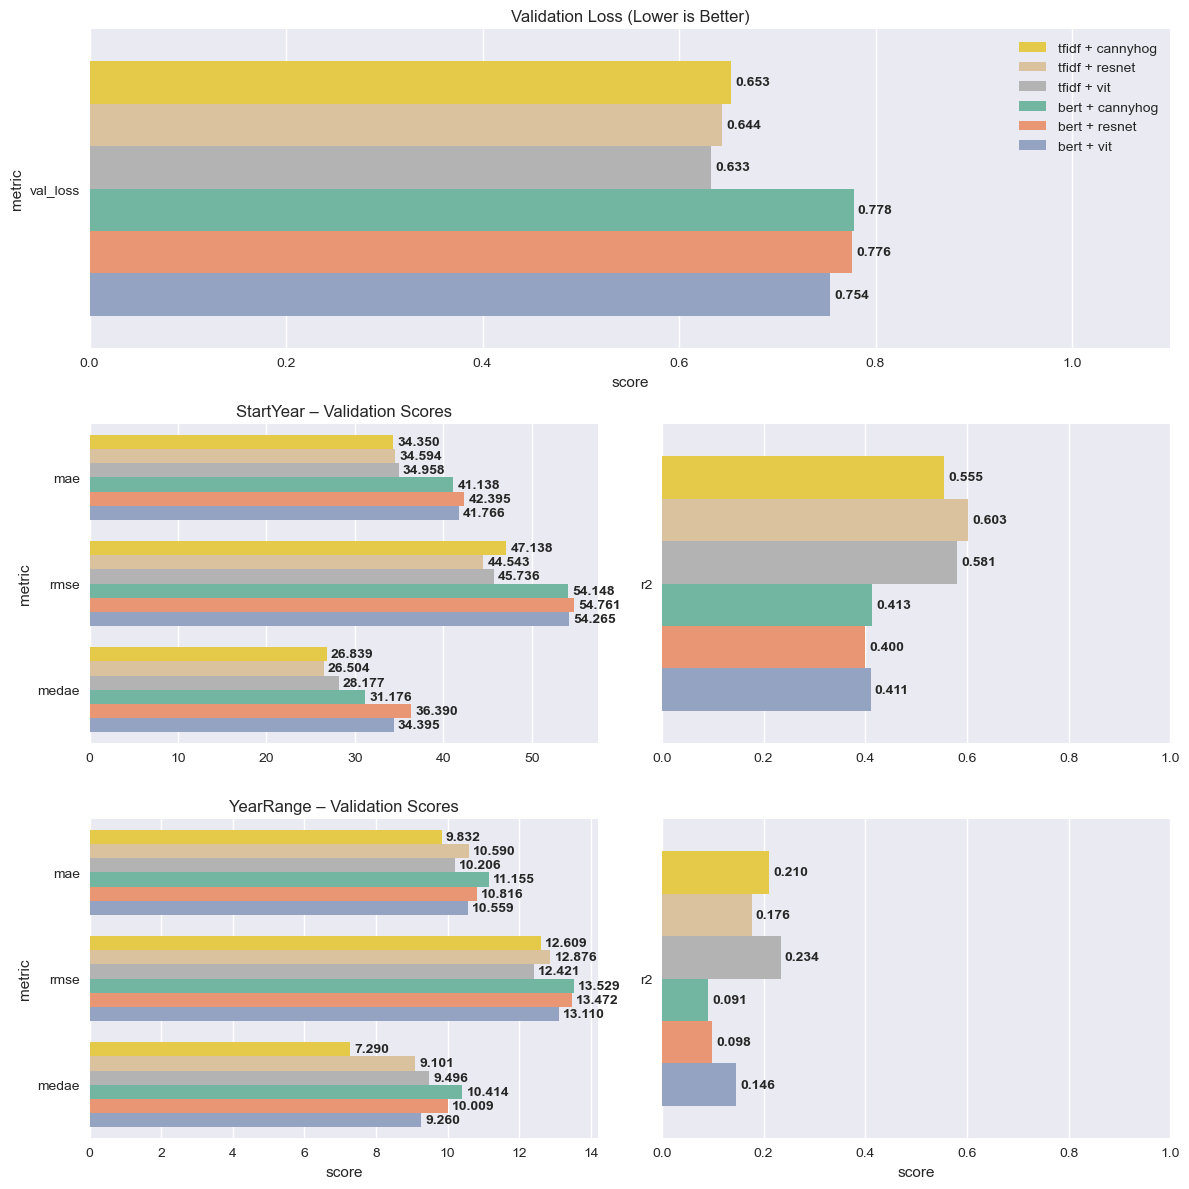

In [28]:
plot_mlp_comparison(
    {" + ".join(fts): best_params[" + ".join(fts)] for fts in feature_type_combos},
    {" + ".join(fts): feature_colors[" + ".join(fts)] for fts in feature_type_combos},
    targets
)

### Build Model

In [29]:
fts = ["tfidf", "vit"]
ft = " + ".join(fts)
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                   relu
blocks                          1
dropout                       0.2
hidden_size                   512
hidden_size_pattern    decreasing
lr                          0.005
Name: value, dtype: object

In [30]:
model_cmb = PotteryChronologyPredictor(
    [X_dim[_ft] for _ft in fts],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_img.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 768]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 768]                  [1, 64]                   --                        --
│    │    └─Linear: 3-1                  [1, 768]                  [1, 64]                   49,216                    49,216
│    │    └─GELU: 3-2                    [1, 64]                   [1, 64]                   --                        --
│    │    └─Dropout: 3-3                 [1, 64]                   [1, 64]                   --                        --
├─Sequential: 1-2                        [1, 64]                   [1, 2]                    --                        --
│    └─Linear

### Train Model

In [31]:
model_cmb, history_cmb = train(
    model_cmb,
    loaders["train"][ft],
    loaders["val"][ft],
    criterion,
    metrics,
    y_scaler,
    lr=params["lr"],
)

** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1123.67it/s, loss=0.6989]

** Early stop | ran: 14/50 epochs | final: epoch 04 | train_loss: 0.4406, val_loss: 0.6686, mae: [35.93, 10.38], rmse: [47.60, 12.79], r2: [0.55, 0.19], medae: [28.07, 9.10], 


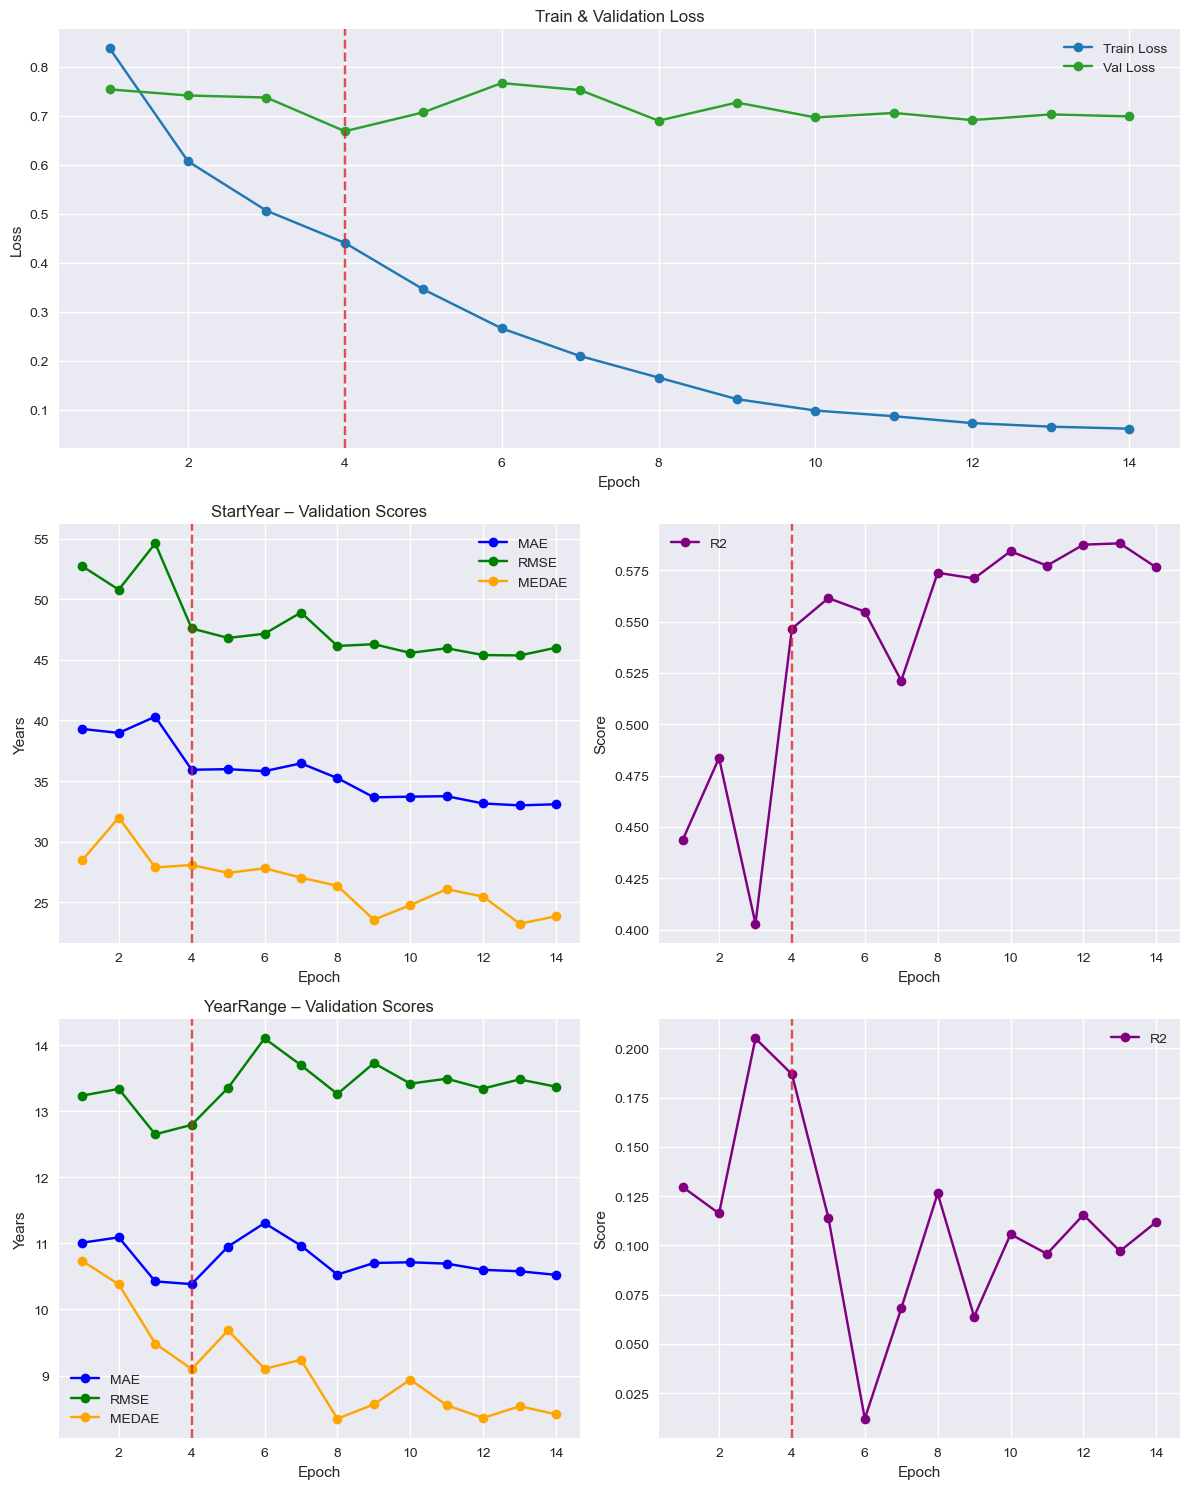

In [32]:
plot_history(history_cmb, targets)

### Save Model Weights

In [33]:
path_model = os.path.join(path_models, f"pottery_chronology_predictor_{"_".join(fts)}.pt")
torch.save(model_cmb.state_dict(), path_model)